# Final Project - Criteo Labs Display Advertising Challenge
__`MIDS w261: Machine Learning at Scale | UC Berkeley School of Information | Spring 2019`__

__`Team: Chi Iong Ansjory, Catherine Cao, Scott Xu`__

Table of Content:
- [0. Background](#background)
- [1. Question Formulation](#question_formulation)
- [2. Algorithm Explanation](#algorithm_explanation)
- [3. EDA & Discussion of Challenges](#eda_challenges)
- [4. Algorithm Implementation](#algorithm_implementation)
- [5. Application of Course Concepts](#course_concepts_application)

<a id='background'></a>
# 0. Background

Criteo Labs is a leading global technology company that specializes in performance display advertising, working with over 4,000 e-commerce companies around the world. Their technology takes an algorithmic approach to determining what user they show an advertisement to, when, and for what products. For billions of unique advertisements that are created and displayed at lightning fast speeds every day.

Display advertising is a billion dollar effort and one of the central uses of Machine Learning on the Internet. However, its data and methods are usually kept confidential. Through the Kaggle research competition, Criteo Labs is sharing a week’s worth of data for participants to develop models predicting advertisement click-through rate (CTR). Given a user and the page being visited, what is the probability that the user will click on a given advertisement?

Source: https://www.kaggle.com/c/criteo-display-ad-challenge

For the dataset, the smaller version is no longer available from Kaggle. The full-size version needs to be used instead from Criteo Labs.

Source: https://www.kaggle.com/c/criteo-display-ad-challenge/data (smaller version - obsoleted); http://labs.criteo.com/2014/02/kaggle-display-advertising-challenge-dataset/ (full-size version)

### Notebook Set-Up

In [6]:
# imports
import re
import ast
import time
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
import os

In [7]:
%reload_ext autoreload
%autoreload 2

In [8]:
# store path to notebook
PWD = !pwd
PWD = PWD[0]

In [10]:
# start Spark Session
from pyspark.sql import SparkSession
app_name = "hw4_notebook"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

from pyspark.sql.types import *
import pyspark.sql.functions as F

In [11]:
# load the raw data into an RDD
toyRDD = sc.textFile('data/toy_train.txt')
trainRDD = sc.textFile('data/train.txt')

<a id='question_formulation'></a>
# 1. Question Formulation

The goal of this analysis is to benchmark the most accurate ML algorithms for CTR estimation.

<a id='algorithm_explanation'></a>
# 2. Algorithm Explanation

<a id='eda_challenges'></a>
# 3. EDA & Discussion of Challenges

The main challenges are the dataset given for this analysis has no column labels. We can't leverage any of our pre-existing knowledge about how online ads are served and CTR is computed in understanding the data. This means we have to put in extra effort in analyzing the data so we can understand the relationships between different features in the dataset and process them appropriately.

In [24]:
# take a look at raw data
trainRDD.take(5)

['0\t1\t1\t5\t0\t1382\t4\t15\t2\t181\t1\t2\t\t2\t68fd1e64\t80e26c9b\tfb936136\t7b4723c4\t25c83c98\t7e0ccccf\tde7995b8\t1f89b562\ta73ee510\ta8cd5504\tb2cb9c98\t37c9c164\t2824a5f6\t1adce6ef\t8ba8b39a\t891b62e7\te5ba7672\tf54016b9\t21ddcdc9\tb1252a9d\t07b5194c\t\t3a171ecb\tc5c50484\te8b83407\t9727dd16',
 '0\t2\t0\t44\t1\t102\t8\t2\t2\t4\t1\t1\t\t4\t68fd1e64\tf0cf0024\t6f67f7e5\t41274cd7\t25c83c98\tfe6b92e5\t922afcc0\t0b153874\ta73ee510\t2b53e5fb\t4f1b46f3\t623049e6\td7020589\tb28479f6\te6c5b5cd\tc92f3b61\t07c540c4\tb04e4670\t21ddcdc9\t5840adea\t60f6221e\t\t3a171ecb\t43f13e8b\te8b83407\t731c3655',
 '0\t2\t0\t1\t14\t767\t89\t4\t2\t245\t1\t3\t3\t45\t287e684f\t0a519c5c\t02cf9876\tc18be181\t25c83c98\t7e0ccccf\tc78204a1\t0b153874\ta73ee510\t3b08e48b\t5f5e6091\t8fe001f4\taa655a2f\t07d13a8f\t6dc710ed\t36103458\t8efede7f\t3412118d\t\t\te587c466\tad3062eb\t3a171ecb\t3b183c5c\t\t',
 '0\t\t893\t\t\t4392\t\t0\t0\t0\t\t0\t\t\t68fd1e64\t2c16a946\ta9a87e68\t2e17d6f6\t25c83c98\tfe6b92e5\t2e8a689b\t0b15387

In [12]:
# split variables
temp_var = trainRDD.map(lambda x: x.split("\t"))

In [13]:
# creating header for data
numeric_features = ['I'+str(i) for i in range(1, 14)]
categorical_features = ['C'+str(i) for i in range(1, 27)]
header = ['target'] + numeric_features + categorical_features

In [15]:
# create pyspark dataframe
train_df = temp_var.toDF(header)
train_df.show()

+------+---+---+---+---+-----+---+---+---+----+---+---+---+---+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|target| I1| I2| I3| I4|   I5| I6| I7| I8|  I9|I10|I11|I12|I13|      C1|      C2|      C3|      C4|      C5|      C6|      C7|      C8|      C9|     C10|     C11|     C12|     C13|     C14|     C15|     C16|     C17|     C18|     C19|     C20|     C21|     C22|     C23|     C24|     C25|     C26|
+------+---+---+---+---+-----+---+---+---+----+---+---+---+---+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|     0|  1|  1|  5|  0| 1382|  4| 15|  2| 181|  1|  2|   |  2|68fd1e64|80e26c9b|fb936136|7b4723c4|25c83c9

In [16]:
# cast integer variables to integer type
for var in ['target'] + numeric_features:
    train_df =train_df.withColumn(var, train_df[var].cast(IntegerType()))

In [10]:
# check schema
train_df.printSchema()

root
 |-- target: integer (nullable = true)
 |-- I1: integer (nullable = true)
 |-- I2: integer (nullable = true)
 |-- I3: integer (nullable = true)
 |-- I4: integer (nullable = true)
 |-- I5: integer (nullable = true)
 |-- I6: integer (nullable = true)
 |-- I7: integer (nullable = true)
 |-- I8: integer (nullable = true)
 |-- I9: integer (nullable = true)
 |-- I10: integer (nullable = true)
 |-- I11: integer (nullable = true)
 |-- I12: integer (nullable = true)
 |-- I13: integer (nullable = true)
 |-- C1: string (nullable = true)
 |-- C2: string (nullable = true)
 |-- C3: string (nullable = true)
 |-- C4: string (nullable = true)
 |-- C5: string (nullable = true)
 |-- C6: string (nullable = true)
 |-- C7: string (nullable = true)
 |-- C8: string (nullable = true)
 |-- C9: string (nullable = true)
 |-- C10: string (nullable = true)
 |-- C11: string (nullable = true)
 |-- C12: string (nullable = true)
 |-- C13: string (nullable = true)
 |-- C14: string (nullable = true)
 |-- C15: string

In [11]:
# how many records do we have
total_count = train_df.count()
total_count

45840617

In [43]:
# take a look at data
pd.DataFrame(train_df.take(5), columns=train_df.columns).transpose()

,0,1,2,3,4
target,0,0,0,0,0
I1,1,2,2,NaN,3
I2,1,0,0,893,-1
I3,5,44,1,NaN,NaN
I4,0,1,14,NaN,0
I5,1382,102,767,4392,2
I6,4,8,89,NaN,0
I7,15,2,4,0,3
I8,2,2,2,0,0
I9,181,4,245,0,0


In [95]:
# for some reason missing categorical variables are not recognized as NA, replacing with the None here
train_df = train_df.replace('', None, categorical_features)

In [97]:
# look at missing statistics
non_missing = train_df.summary("count")
missing_summary = non_missing.toPandas().drop(['summary'], axis=1).transpose()
missing_summary.columns = ['non-missing']
missing_summary['missing'] = total_count - missing_summary['non-missing'].astype('int64')
missing_summary['missing_pct'] = missing_summary['missing'] / total_count
missing_summary.sort_values(['missing_pct'], ascending=False)

,non-missing,missing,missing_pct
I12,10768965,35071652,0.765078
C22,10885544,34955073,0.762535
I1,25047061,20793556,0.453606
I10,25047061,20793556,0.453606
C26,25667759,20172858,0.440065
C25,25667759,20172858,0.440065
C20,25667759,20172858,0.440065
C19,25667759,20172858,0.440065
I6,35588289,10252328,0.223652
I4,35903248,9937369,0.216781


In [14]:
# look at target variable distribution - fairly balanced
train_df.groupBy('target').count().toPandas()

,target,count
0,1,11745438
1,0,34095179


In [100]:
# look at summary statistics of numeric features
num_summary = train_df.select(numeric_features).describe()
num_summary_pd = num_summary.toPandas().transpose()
num_summary_pd.columns = num_summary_pd.iloc[0]
num_summary_pd = num_summary_pd[1:]
num_summary_pd

summary,count,mean,stddev,min,max
I1,25047061,3.5024133170754044,9.429076407105066,0,5775
I2,45840617,105.84841979766546,391.4578226870704,-3,257675
I3,36001170,26.913041020611274,397.97258302273394,0,65535
I4,35903248,7.322680248873305,8.793230712645798,0,969
I5,44657500,18538.991664871523,69394.60184622336,0,23159456
I6,35588289,116.06185085211598,382.56644937124,0,431037
I7,43857751,16.333130032135028,66.04975524511714,0,56311
I8,45817844,12.517042137556713,16.68888456778756,0,6047
I9,43857751,106.1098234380509,220.28309398648,0,29019
I10,25047061,0.6175294977722137,0.6840505553977021,0,11


In [17]:
# take 1% of data as a sample for more EDA
sample = train_df.sample(0.01, 666)
sample.count()

459205

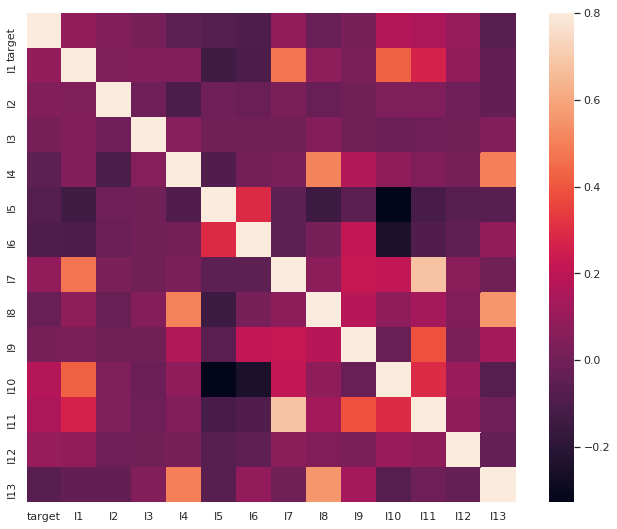

In [173]:
# correlation matrix of numeric features on sample data
numeric_data = sample.select(['target'] + numeric_features).toPandas()
corrmat = numeric_data.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)

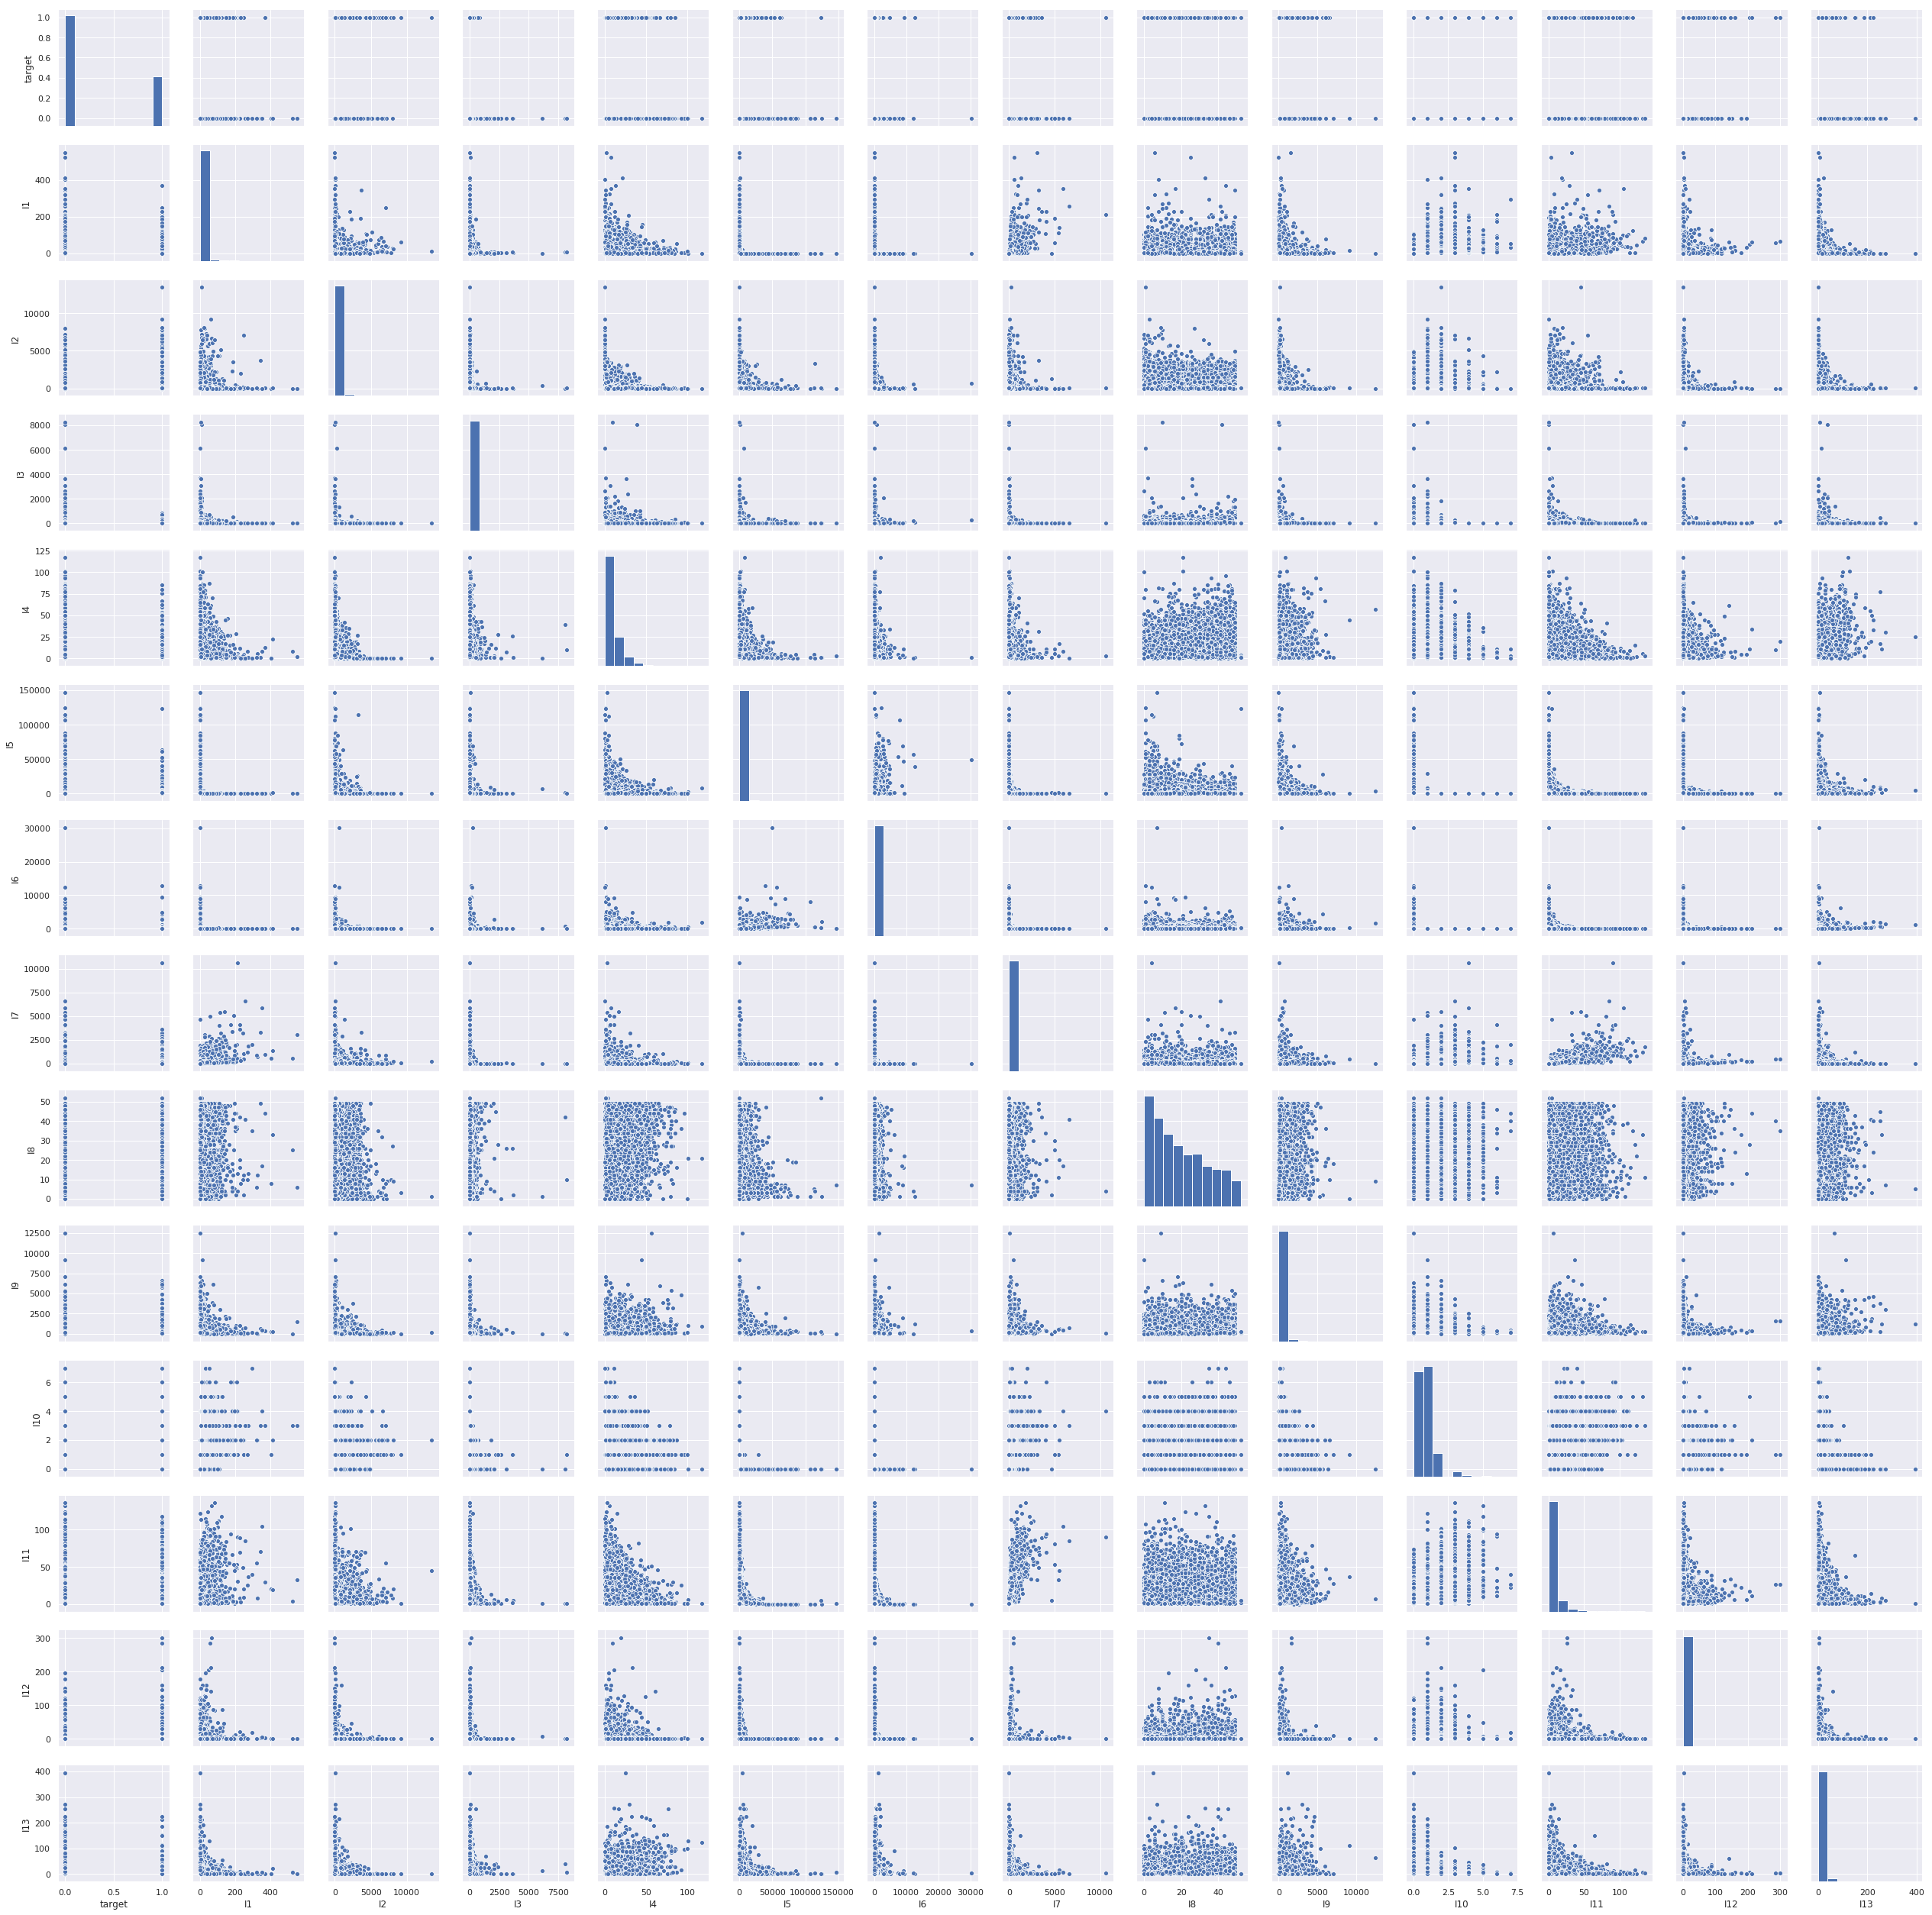

In [35]:
#scatterplot of numeric features
sample_pd = sample.toPandas()
sample_nona = sample_pd.dropna()
sns.set()
cols = ['target'] + numeric_features
sns.pairplot(sample_nona[cols], height = 2.5)
plt.show()

In [172]:
# look at summary statistics of categorical features in sample (levels, mode)
cat_summary = pd.DataFrame()
for i in categorical_features:
    cached = sample.groupBy(i).count().cache()
    mode = cached.orderBy('count', ascending=0).filter(i + "!=''").limit(1).toPandas()
    level = cached.count()
    mode['level'] = level
    mode['var'] = i
    mode.rename(columns={i:'mode'}, inplace=True)
    cat_summary = cat_summary.append(mode, ignore_index = True)
cat_summary

,mode,count,level,var
0,05db9164,229880,993,C1
1,38a947a1,52183,542,C2
2,d032c263,11414,181656,C3
3,c18be181,16378,79764,C4
4,25c83c98,309003,220,C5
5,7e0ccccf,182511,15,C6
6,1c86e0eb,9465,10479,C7
7,0b153874,272482,456,C8
8,a73ee510,412667,3,C9
9,3b08e48b,101627,23613,C10


In [186]:
# impute missing values - numeric features impute with mean, categorical features impute with mode
num_means = list(num_summary_pd['mean'].astype('float64'))
cat_modes = list(cat_summary['mode'])
impute = dict(zip(numeric_features+categorical_features, num_means+cat_modes))
impute

{'I1': 3.5024133170754044,
 'I2': 105.84841979766546,
 'I3': 26.913041020611274,
 'I4': 7.322680248873305,
 'I5': 18538.991664871523,
 'I6': 116.06185085211598,
 'I7': 16.333130032135028,
 'I8': 12.517042137556713,
 'I9': 106.1098234380509,
 'I10': 0.6175294977722137,
 'I11': 2.7328343170173044,
 'I12': 0.9910356287721244,
 'I13': 8.217461161174054,
 'C1': '05db9164',
 'C2': '38a947a1',
 'C3': 'd032c263',
 'C4': 'c18be181',
 'C5': '25c83c98',
 'C6': '7e0ccccf',
 'C7': '1c86e0eb',
 'C8': '0b153874',
 'C9': 'a73ee510',
 'C10': '3b08e48b',
 'C11': '755e4a50',
 'C12': 'dfbb09fb',
 'C13': '5978055e',
 'C14': 'b28479f6',
 'C15': '2d0bb053',
 'C16': '84898b2a',
 'C17': 'e5ba7672',
 'C18': 'e88ffc9d',
 'C19': '21ddcdc9',
 'C20': 'b1252a9d',
 'C21': '0014c32a',
 'C22': 'ad3062eb',
 'C23': '32c7478e',
 'C24': '3fdb382b',
 'C25': '001f3601',
 'C26': '49d68486'}

In [189]:
# impute missing and take a look at imputed data
train_df_impute = train_df.fillna(impute)
pd.DataFrame(train_df_impute.take(10), columns=train_df_impute.columns).transpose()

,0,1,2,3,4,5,6,7,8,9
target,0,0,0,0,0,0,0,1,0,0
I1,1,2,2,3,3,3,3,1,3,3
I2,1,0,0,893,-1,-1,1,4,44,35
I3,5,44,1,26,26,26,2,2,4,26
I4,0,1,14,7,0,7,7,0,8,1
I5,1382,102,767,4392,2,12824,3168,0,19010,33737
I6,4,8,89,116,0,116,116,0,249,21
I7,15,2,4,0,3,0,0,1,28,1
I8,2,2,2,0,0,0,1,0,31,2
I9,181,4,245,0,0,6,2,0,141,3


<a id='algorithm_implementation'></a>
# 4. Algorithm Implementation

<a id='course_concepts_application'></a>
# 5. Application of Course Concepts